In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from math import log2, floor
from IPython.display import HTML

%matplotlib inline

# Models

## DCGAN

In [ ]:
class DCGAN(nn.Module):
    """Deep Convolutional Generative Adversarial Network"""

    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,):
        """
        Initializes DCGAN.

        Args:
            num_latents: Number of latent factors.
            num_features: Number of features in the convolutions.
            image_channels: Number of channels in the input image.
            image_size: Size (i.e. height or width) of image.
            gan_type: Type of GAN (e.g. "gan" or "wgan-gp").
        """
        super().__init__()

        self.num_latents = num_latents
        self.num_features = num_features
        self.image_channels = image_channels
        self.image_size = image_size
        self.gan_type = gan_type
        self.fully_convolutional = fully_convolutional
        self.activation = activation
        self.use_batchnorm = use_batchnorm
        self.use_spectralnorm = use_spectralnorm

        D_params = {
            "num_latents": 1,  # XXX
            "num_features": num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
        }
        G_params = {
            "num_latents": num_latents,
            "num_features": num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
        }

        self.D = DCGAN_Discriminator(**D_params)
        self.G = DCGAN_Generator(**G_params)


class DCGAN_DiscriminatorBlock(nn.Module):
    """
    A discriminator convolutional block.
    Default stride and padding half the size of features,
    e.g. if input is [in_channels, 64, 64], output will be [out_channels, 32, 32].
    """

    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.conv = nn.utils.spectral_norm(self.conv)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.LeakyReLU(0.2, inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class DCGAN_GeneratorBlock(nn.Module):
    """
    A generator convolutional block.
    Default stride and padding double the size of features,
    e.g. if input is [in_channels, 32, 32], output will be [out_channels, 64, 64].
    """

    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                                        stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.convT = nn.utils.spectral_norm(self.convT)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.LeakyReLU(0.2, inplace=True) if activation is None else activation() # XXX: ReLU?

    def forward(self, x):
        x = self.convT(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class DCGAN_Discriminator(nn.Module):
    """The discriminator of a DCGAN"""

    def __init__(self,
                 num_latents=1,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 D_block=DCGAN_DiscriminatorBlock):
        super().__init__()

        using_grad_penalty = gan_type in ("gan-gp", "wgan-gp")
        output_sigmoid = gan_type in ("gan", "gan-gp")

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm and not using_grad_penalty,
            "use_spectralnorm": use_spectralnorm,
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(num_features * 2**i, max_features) for i in range(num_layers)]

        # Input layer
        self.input_layer = D_block(image_channels, features[0], **block_config)

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            D_block(in_features, out_features, **block_config)
            for in_features, out_features in zip(features, features[1:])
        ])

        # Output layer (feature_size = 3, 4, or 5 -> 1)
        if fully_convolutional:
            self.output_layer = nn.Sequential(
                nn.Conv2d(features[-1], num_latents, latent_kernel, bias=False),
                nn.Flatten(),
            )
        else:
            self.output_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(features[-1] * latent_kernel**2, num_latents, bias=False)
            )

        # Add sigmoid activation if using regular GAN loss
        self.output_activation = nn.Sigmoid() if output_sigmoid else None

    def forward(self, x):
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        if self.output_activation:
            x = self.output_activation(x)
        # Remove H and W dimensions, infer channels dim (remove if 1)
        x = x.view(x.size(0), -1).squeeze(1)
        return x


class DCGAN_Generator(nn.Module):
    """The generator of a DCGAN"""

    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 G_block=DCGAN_GeneratorBlock):
        super().__init__()

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(num_features * 2**i, max_features) for i in range(num_layers)]

        # Reverse order of image sizes and features for generator
        image_sizes = image_sizes[::-1]
        features = features[::-1]

        # Input layer
        if fully_convolutional:
            self.input_layer = G_block(num_latents, features[0], kernel_size=latent_kernel,
                                       stride=1, padding=0, **block_config)
        else:
            self.input_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_latents, features[0] * image_sizes[0]**2, bias=False),
                View(features[0], image_sizes[0], image_sizes[0])
            )

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            G_block(in_features, out_features, kernel_size=4+(expected_size%2), **block_config)
            for in_features, out_features, expected_size in zip(features, features[1:], image_sizes[1:])
        ])

        # Output layer
        self.output_layer = nn.ConvTranspose2d(features[-1], image_channels, kernel_size=4+(image_size%2),
                                               stride=2, padding=1, bias=False)
        self.output_activation = nn.Tanh()

    def forward(self, x):
        # Add H and W dimensions, infer channels dim (add if none)
        x = x.view(x.size(0), -1, 1, 1)
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x


class View(nn.Module):
    def __init__(self, *shape, including_batch=False):
        super().__init__()
        self.shape = shape
        self.including_batch = including_batch
    
    def forward(self, x):
        if self.including_batch:
            return x.view(*self.shape)
        else:
            return x.view(x.size(0), *self.shape)


## RAE

In [ ]:
class RAE(nn.Module):
    """
    Regularized Auto-encoders.
    """
    def __init__(self, encoder=None, decoder=None, noise_std=0.01, *args, **kwargs):
        super().__init__()
        self.encoder = DCGAN_Discriminator(*args, **kwargs) if encoder is None else encoder
        self.decoder = DCGAN_Generator(*args, **kwargs) if decoder is None else decoder
        self.noise_std = noise_std
    
    def sample_latent(self, x):
        device = x.device
        with torch.no_grad():
            z = self.encoder(x)
        # Just in case
        z = z.view(z.size(0), -1)
        batch_size, num_latents = z.size()
        # The covariance of z.t()
        mu = z.mean(dim=0, keepdim=True)
        z -= mu # normalize
        z_cov = z.t() @ z / (batch_size-1)  # (num_latents, num_latents)
        z_cov += 1e-5 * torch.eye(num_latents).to(z)  # to avoid singular matrix
        sampler = MultivariateNormal(mu.cpu().squeeze(), z_cov.cpu())
        samples = torch.stack([sampler.sample() for _ in range(batch_size)])
        return samples.to(device)

    def reconstruct(self, z):
        with torch.no_grad():
            x_re = self.decoder(z)
        return x_re
    
    def sample(self, x):
        z = self.sample_latent(x)
        x_re = self.reconstruct(z)
        return x_re, z
    
    def forward(self, x, noise_std=None):
        noise_std = self.noise_std if noise_std is None else noise_std
        z = self.encoder(x)
        z = z + torch.randn_like(z) * noise_std
        x_re = self.decoder(z)
        return x_re, z

# Dataset

## Download MNIST

In [ ]:
def MNISTDataset(batch_size=8, num_workers=0, image_size=28):
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])

    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return trainloader, testloader

MNISTDataset() # Just to download

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(<torch.utils.data.dataloader.DataLoader at 0x7f673ba5a2e8>,
 <torch.utils.data.dataloader.DataLoader at 0x7f673ba55d68>)

## Test model

In [ ]:
### Test for different image sizes ###
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for image_size in range(6, 33):
    trainloader, _ = MNISTDataset(image_size=image_size)
    rae = RAE(image_channels=1, image_size=image_size, num_latents=10,
              fully_convolutional=False, activation=nn.ReLU,
              use_batchnorm=False, use_spectralnorm=True).to(device)
    x, _ = next(iter(trainloader))
    x_re, _ = rae(x.to(device))
    assert x.size() == x_re.size()
    print(f"{image_size}: Good");

6: Good
7: Good
8: Good
9: Good
10: Good
11: Good
12: Good
13: Good
14: Good
15: Good
16: Good
17: Good
18: Good
19: Good
20: Good
21: Good
22: Good
23: Good
24: Good
25: Good
26: Good
27: Good
28: Good
29: Good
30: Good
31: Good
32: Good


# Training

## Prepare for training

### Hyperparameters

In [ ]:
### MNIST ###
image_size = 28
image_channels = 1

### Hyperparameters ###
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
num_workers = 8
num_latents = 50
num_features = 16
num_epochs = 10
report_interval = 20
use_spectralnorm = False
use_gradnorm = True
z_sparsity = True
optimizer = torch.optim.Adam
lr = 2e-4

### Define dataset, model, optimizer, and loss functions

In [ ]:
# Dataset, model, optimizer
trainloader, testloader = MNISTDataset(batch_size, num_workers, image_size)
rae = RAE(image_channels=image_channels, image_size=image_size,
          num_latents=num_latents, num_features=num_features)
optim = optimizer(rae.parameters(), lr=lr)

# Losses
def reconstruction_loss(x, y):
    return 0.5 * (x - y).pow(2).flatten(start_dim=1).sum(dim=1).mean()
    #return F.mse_loss(x, y)

def rae_loss(z):
    return 0.5 * z.pow(2).flatten(start_dim=1).sum(dim=1).mean()
    #return F.mse_loss(z, torch.zeros_like(z))

def grad_norm(x_re, z):
    grad = torch.autograd.grad(x_re, z, torch.ones_like(x_re), retain_graph=True)
    grad_norm = grad[0].flatten(start_dim=1).norm(dim=1)
    return grad_norm

def gradnorm_penalty(x_re, z):
    return grad_norm(x_re, z).mean()

def num_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("Number of parameters =", num_parameters(rae))

Number of parameters = 158912


## Start training

In [ ]:
%%time
### Train ###
rae.train()
rae = rae.to(device)
fixed_x, _ = next(iter(testloader))
fixed_x = fixed_x.to(device)

losses = []
reconstructions = []
for epoch in range(num_epochs):
    for iters, data in enumerate(trainloader):
        optim.zero_grad()
        x, y = data
        x, y = x.to(device), y.to(device)
        x_re, z = rae(x)

        loss = reconstruction_loss(x_re, x)
        if use_gradnorm:
            loss += 0.02 * gradnorm_penalty(x_re, z)
        if z_sparsity:
            loss += z.abs().sum(dim=-1).mean()
        loss += rae_loss(z)
        loss.backward()
        optim.step()

        if (iters+1) % report_interval == 0:
            progress = f"[{epoch+1}/{num_epochs}][{iters+1}/{len(trainloader)}]"
            loss_stats = f"Loss = {loss.item():.4f}"
            print(progress, loss_stats)
            with torch.no_grad():
                fixed_x_re, _ = rae(fixed_x)
                reconstruction = torch.cat([fixed_x, fixed_x_re], dim=0).detach().cpu()
            reconstructions.append(reconstruction)
            losses.append(loss.item())

[1/10][20/938] Loss = 313.2430
[1/10][40/938] Loss = 246.5394
[1/10][60/938] Loss = 208.6937
[1/10][80/938] Loss = 186.8714
[1/10][100/938] Loss = 168.7387
[1/10][120/938] Loss = 154.3584
[1/10][140/938] Loss = 146.4600
[1/10][160/938] Loss = 131.2747
[1/10][180/938] Loss = 118.6847
[1/10][200/938] Loss = 116.7774
[1/10][220/938] Loss = 107.5730
[1/10][240/938] Loss = 98.7142
[1/10][260/938] Loss = 93.3058
[1/10][280/938] Loss = 86.5999
[1/10][300/938] Loss = 81.2389
[1/10][320/938] Loss = 78.7415
[1/10][340/938] Loss = 72.7291
[1/10][360/938] Loss = 69.6185
[1/10][380/938] Loss = 72.4878
[1/10][400/938] Loss = 65.0287
[1/10][420/938] Loss = 61.0261
[1/10][440/938] Loss = 59.7912
[1/10][460/938] Loss = 56.1785
[1/10][480/938] Loss = 54.3277
[1/10][500/938] Loss = 54.5360
[1/10][520/938] Loss = 50.9058
[1/10][540/938] Loss = 51.1598
[1/10][560/938] Loss = 47.9692
[1/10][580/938] Loss = 48.9878
[1/10][600/938] Loss = 45.5398
[1/10][620/938] Loss = 47.6205
[1/10][640/938] Loss = 42.8391
[

## Results

### Loss

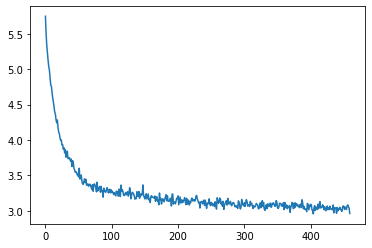

In [ ]:
# Using log scale to examine convergence
_ = plt.plot(np.log(np.array(losses)))

### Show reconstructions

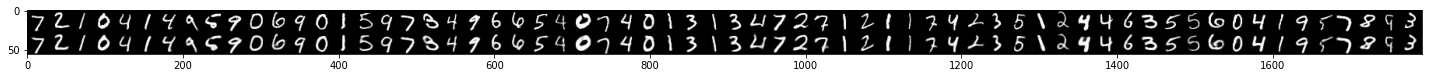

In [ ]:
image_grid = torchvision.utils.make_grid(reconstructions[-1], nrow=batch_size, padding=0, normalize=True, range=(-1,1))
fig = plt.figure(figsize=(25, 20))
plt.imshow(image_grid.permute(1,2,0), cmap="gray")

In [ ]:
frames = reconstructions[:]
max_frames = 100

fig = plt.figure(figsize=(19, 3))
frame_rate = max(1, int(round(len(frames) / max_frames)))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
grids = [
    torchvision.utils.make_grid(r, nrow=batch_size, normalize=True, padding=1, range=(-1,1))
    for r in frames[::frame_rate]
]
ims = [[plt.imshow(grid.permute(1,2,0), cmap="gray", animated=True, aspect="auto")] for grid in grids]
ani = animation.ArtistAnimation(fig, ims, blit=True)
plt.close(fig)
HTML(ani.to_html5_video())

### Sampling latent space

In [ ]:
_, testloader = MNISTDataset(batch_size=8, num_workers=num_workers, image_size=image_size)
testset_iter = iter(testloader)

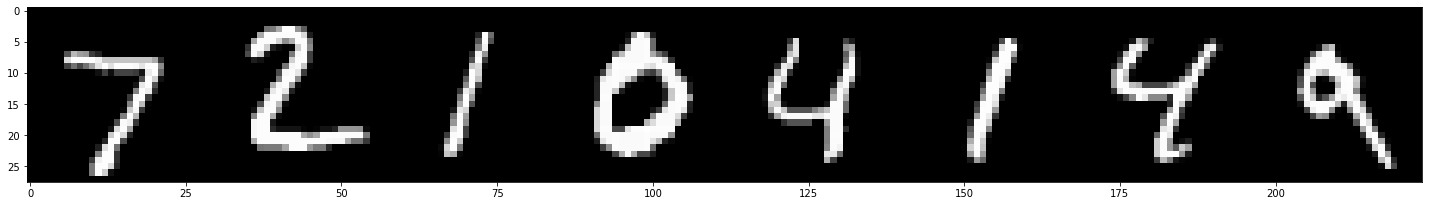

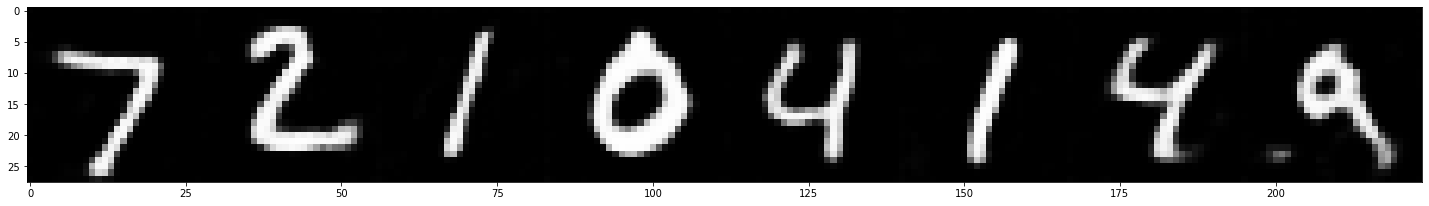

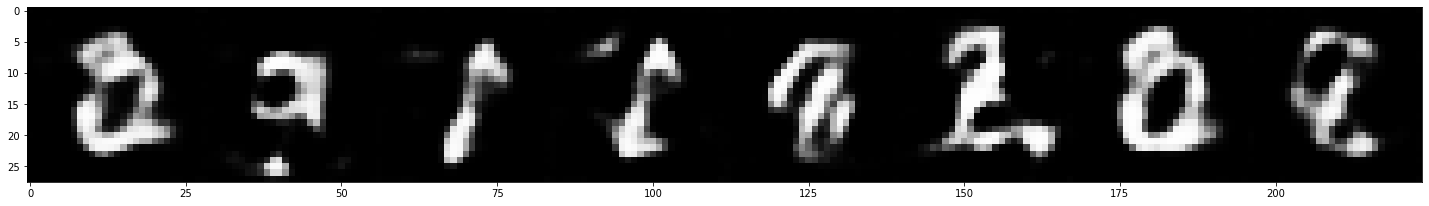

In [ ]:
x, _ = next(testset_iter)
x = x.to(device)

with torch.no_grad():
    x_re, _ = rae(x)
z_sample = rae.sample_latent(x)
x_re_sample = rae.reconstruct(z_sample)

fig1 = plt.figure(figsize=(25, 20))
image_grid = torchvision.utils.make_grid(x[:batch_size].cpu(), nrow=batch_size, padding=0, normalize=True, range=(-1,1))
plt.imshow(image_grid.permute(1,2,0), cmap="gray")

fig2 = plt.figure(figsize=(25, 20))
image_grid = torchvision.utils.make_grid(x_re[:batch_size].cpu(), nrow=batch_size, padding=0, normalize=True, range=(-1,1))
plt.imshow(image_grid.permute(1,2,0), cmap="gray")

fig2 = plt.figure(figsize=(25, 20))
image_grid = torchvision.utils.make_grid(x_re_sample[:batch_size].cpu(), nrow=batch_size, padding=0, normalize=True, range=(-1,1))
plt.imshow(image_grid.permute(1,2,0), cmap="gray")

## Test represention of latent space

### Train a simple classifier on the latent code of the image

In [ ]:
class LatentClassifier(nn.Module):
    def __init__(self, n_hidden=0, num_latents=num_latents):
        super().__init__()
        hidden_layers = []
        for _ in range(n_hidden):
            hidden_layers += [nn.Linear(num_latents, num_latents),
                              nn.ReLU()]
        self.main = nn.Sequential(*hidden_layers, nn.Linear(num_latents, 10))

    def forward(self, x):
        return self.main(x)

In [ ]:
n_hidden = 3
trainloader, testloader = MNISTDataset(batch_size, num_workers, image_size)
classifier = LatentClassifier(n_hidden=n_hidden, num_latents=num_latents)
classifier_optim = torch.optim.Adam(classifier.parameters())
classifier_loss = nn.CrossEntropyLoss()
num_parameters(classifier)

8160

In [ ]:
%%time
### Train ###
classifier.train()
classifier = classifier.to(device)
losses = []
for epoch in range(num_epochs):
    for iters, data in enumerate(trainloader):
        classifier_optim.zero_grad()
        x, y = data
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            z = rae.encoder(x)
        y_pred = classifier(z)

        loss = classifier_loss(y_pred, y)
        loss.backward()
        classifier_optim.step()

        if (iters+1) % report_interval == 0:
            progress = f"[{epoch+1}/{num_epochs}][{iters+1}/{len(trainloader)}]"
            loss_stats = f"Loss = {loss.item():.4f}"
            hits = (y_pred.argmax(dim=1) == y).sum()
            accuracy_stats = f"Accuracy = {hits.float() / y.size(0) * 100 :.2f}%"
            print(f"{progress} {loss_stats}, {accuracy_stats}")
            losses.append(loss.item())

[1/10][20/938] Loss = 2.3050, Accuracy = 12.50%
[1/10][40/938] Loss = 2.3014, Accuracy = 12.50%
[1/10][60/938] Loss = 2.2612, Accuracy = 18.75%
[1/10][80/938] Loss = 2.1682, Accuracy = 51.56%
[1/10][100/938] Loss = 2.0214, Accuracy = 28.12%
[1/10][120/938] Loss = 1.8063, Accuracy = 23.44%
[1/10][140/938] Loss = 1.6922, Accuracy = 43.75%
[1/10][160/938] Loss = 1.5011, Accuracy = 56.25%
[1/10][180/938] Loss = 1.5524, Accuracy = 53.12%
[1/10][200/938] Loss = 1.2589, Accuracy = 60.94%
[1/10][220/938] Loss = 1.1780, Accuracy = 57.81%
[1/10][240/938] Loss = 1.0812, Accuracy = 60.94%
[1/10][260/938] Loss = 1.2575, Accuracy = 67.19%
[1/10][280/938] Loss = 0.8289, Accuracy = 75.00%
[1/10][300/938] Loss = 1.0037, Accuracy = 65.62%
[1/10][320/938] Loss = 1.0439, Accuracy = 59.38%
[1/10][340/938] Loss = 0.8453, Accuracy = 73.44%
[1/10][360/938] Loss = 0.9111, Accuracy = 68.75%
[1/10][380/938] Loss = 1.0217, Accuracy = 71.88%
[1/10][400/938] Loss = 0.7744, Accuracy = 70.31%
[1/10][420/938] Loss = 0

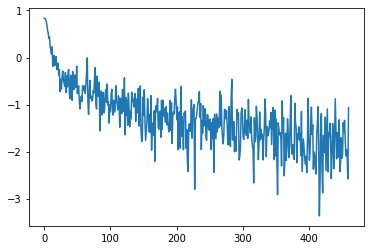

In [ ]:
plt.plot(np.log(np.array(losses)))

In [ ]:
%%time
classifier.eval()
total_hits = 0
total_loss = 0
for iters, data in enumerate(testloader):
    x, y = data
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        z = rae.encoder(x)
        y_pred = classifier(z)

    loss = classifier_loss(y_pred, y)
    hits = (y_pred.argmax(dim=1) == y).sum()

    total_hits += hits.item()
    total_loss += loss.item()

avg_loss = total_loss / len(testloader)
avg_hits = total_hits / (len(testloader) * batch_size)
print(f"Average loss = {avg_loss}")
print(f"Average accuracy = {avg_hits * 100 :.2f}%")

Average loss = 0.17446604152180398
Average accuracy = 94.25%
CPU times: user 493 ms, sys: 300 ms, total: 793 ms
Wall time: 2.31 s


### Train the same simple classifier on dataset and compare

In [ ]:
trainloader, testloader = MNISTDataset(batch_size, num_workers, image_size)
classifier = nn.Sequential(
    nn.Linear(image_size*image_size, num_latents),
    LatentClassifier(n_hidden=n_hidden, num_latents=num_latents),
)
optim = torch.optim.Adam(classifier.parameters())
classifier_loss = nn.CrossEntropyLoss()
num_parameters(classifier)

47410

In [ ]:
%%time
### Train ###
classifier.train()
classifier = classifier.to(device)
losses = []
for epoch in range(num_epochs):
    for iters, data in enumerate(trainloader):
        optim.zero_grad()
        x, y = data
        x, y = x.to(device), y.to(device)
        y_pred = classifier(x.flatten(start_dim=1))

        loss = classifier_loss(y_pred, y)
        loss.backward()
        optim.step()

        if (iters+1) % report_interval == 0:
            progress = f"[{epoch+1}/{num_epochs}][{iters+1}/{len(trainloader)}]"
            loss_stats = f"Loss = {loss.item():.4f}"
            hits = (y_pred.argmax(dim=1) == y).sum()
            accuracy_stats = f"Accuracy = {hits.float() / y.size(0) * 100 :.2f}%"
            print(f"{progress} {loss_stats}, {accuracy_stats}")
            losses.append(loss.item())

[1/10][20/938] Loss = 2.0284, Accuracy = 29.69%
[1/10][40/938] Loss = 1.4243, Accuracy = 59.38%
[1/10][60/938] Loss = 0.9219, Accuracy = 71.88%
[1/10][80/938] Loss = 0.7146, Accuracy = 79.69%
[1/10][100/938] Loss = 0.6353, Accuracy = 81.25%
[1/10][120/938] Loss = 0.7141, Accuracy = 76.56%
[1/10][140/938] Loss = 0.8147, Accuracy = 76.56%
[1/10][160/938] Loss = 0.3121, Accuracy = 92.19%
[1/10][180/938] Loss = 0.5790, Accuracy = 82.81%
[1/10][200/938] Loss = 0.4185, Accuracy = 85.94%
[1/10][220/938] Loss = 0.2328, Accuracy = 95.31%
[1/10][240/938] Loss = 0.5497, Accuracy = 79.69%
[1/10][260/938] Loss = 0.4364, Accuracy = 85.94%
[1/10][280/938] Loss = 0.5255, Accuracy = 81.25%
[1/10][300/938] Loss = 0.6460, Accuracy = 73.44%
[1/10][320/938] Loss = 0.4986, Accuracy = 84.38%
[1/10][340/938] Loss = 0.6197, Accuracy = 81.25%
[1/10][360/938] Loss = 0.3521, Accuracy = 93.75%
[1/10][380/938] Loss = 0.4978, Accuracy = 85.94%
[1/10][400/938] Loss = 0.5301, Accuracy = 85.94%
[1/10][420/938] Loss = 0

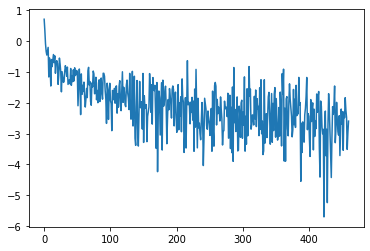

In [ ]:
plt.plot(np.log(np.array(losses)))

In [ ]:
%%time
classifier.eval()
total_hits = 0
total_loss = 0
for iters, data in enumerate(testloader):
    x, y = data
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_pred = classifier(x.flatten(start_dim=1))

    loss = classifier_loss(y_pred, y)
    hits = (y_pred.argmax(dim=1) == y).sum()

    total_hits += hits.item()
    total_loss += loss.item()

avg_loss = total_loss / len(testloader)
avg_hits = total_hits / (len(testloader) * batch_size)
print(f"Average loss = {avg_loss}")
print(f"Average accuracy = {avg_hits * 100 :.2f}%")

Average loss = 0.12297963513167809
Average accuracy = 96.07%
CPU times: user 347 ms, sys: 292 ms, total: 638 ms
Wall time: 2.23 s
